In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from time import time

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fname, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.matlab_helper import loadmat
from mesostat.stat.connectomics import offdiag_1D

from lib.sych.data_fc_db import DataFCDatabase

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


# Calculate for Corr, MI

In [27]:
def norm_discr_hist(data, maxLagTrg):
    tmp = data[~np.isnan(data)]
    rez = np.array([np.sum(tmp==i) for i in range(maxLagTrg+1)])
    return rez / np.sum(rez)

In [3]:
neuroFilePath = gui_fname("neuro_file",  './', '*.mat')

In [4]:
behaviourFile = os.path.join(os.path.dirname(neuroFilePath), 'behaviorvar.mat')

In [5]:
data = loadmat(neuroFilePath)['data']
behav = loadmat(behaviourFile)

In [6]:
behavIGO = behav['iGO']-1
dataIGO = data[behavIGO]

Doing 0 crosscorr
Doing 1 crosscorr
Doing 0 cross_MI
Doing 1 cross_MI


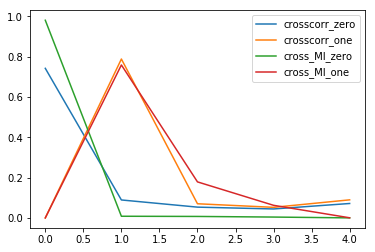

In [30]:
maxLag = 4
window = maxLag + 1

mc = MetricCalculator(serial=False, verbose=False)
mc.set_data(dataIGO, 'rsp', zscoreDim='p', timeWindow=window)


plt.figure()
for metric in ['crosscorr', 'cross_MI']:
    for minLag in [0, 1]:
        print('Doing', minLag, metric)
        
        rezThis = mc.metric3D(metric, 's', metricSettings=None, sweepSettings={'lag' : np.arange(minLag, maxLag+1)})
        rezAbs = np.abs(rezThis)

        rezStack = []
        lagStack = []
        for rezTime in rezAbs:
            rezOffDiag = np.array([offdiag_1D(r) for r in rezTime])
            lagStack += [np.argmax(rezOffDiag, axis=0) + minLag]
            rezStack += [np.max(rezOffDiag, axis=0)]

        rezStack = np.array(rezStack).flatten()
        lagStack = np.array(lagStack).flatten()
        thrCut = np.quantile(rezStack, 0.8)
        idxCut = rezStack > thrCut

        hist = norm_discr_hist(lagStack[idxCut], maxLag)
        
        suffix = '_zero' if minLag == 0 else '_one'
        plt.plot(hist, label=metric+suffix)
    
plt.legend()
plt.savefig('corr_mi_one_zero.svg')
plt.show()

# Read files and plot for TE

In [3]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
params['bte_zero']  = gui_fname("bte_zeros",  './', '*.h5')
params['mte_zero']  = gui_fname("mte_zeros",  params['bte_zero'], '*.h5')
params['bte_one']  = gui_fname("bte_one",  params['mte_zero'], '*.h5')
params['mte_one']  = gui_fname("mte_one",  params['bte_one'], '*.h5')

In [4]:
params

{'bte_zero': '/media/alyosha/Data/TE_data/yarodata/te_0_lag/mtp_15_2018_05_24_a_iGO_BivariateTE_swipe.h5',
 'mte_zero': '/media/alyosha/Data/TE_data/yarodata/te_0_lag/mtp_15_2018_05_24_a_iGO_MultivariateTE_swipe.h5',
 'bte_one': '/media/alyosha/Data/TE_data/yarodata/te/raw_delay_3_window_4/mtp_15_2018_05_24_a_iGO_BivariateTE_swipe.h5',
 'mte_one': '/media/alyosha/Data/TE_data/yarodata/te/raw_delay_3_window_4/mtp_15_2018_05_24_a_iGO_MultivariateTE_swipe.h5'}

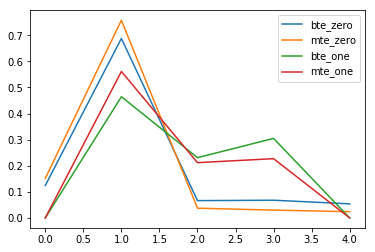

In [28]:
def read_TE_H5(fname):
    h5f = h5py.File(fname, "r")
    data = np.array([
        np.copy(h5f['results']['TE_table']),
        np.copy(h5f['results']['delay_table']),
        np.copy(h5f['results']['p_table'])
    ])
    h5f.close()
    return data

plt.figure()
for k,v in params.items():
    dataThis = read_TE_H5(v)
    rez = norm_discr_hist(dataThis[1].flatten(), 4)
    plt.plot(rez, label=k)
    
plt.legend()
plt.savefig('bte_mte_one_zero.svg')
plt.show()

array([0.12426268, 0.68777035, 0.06626032, 0.06783327, 0.05387338])